In [54]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from statistics import median 
import seaborn as sns
%matplotlib inline

In [55]:
# read training and test set data files
df_train = pd.read_csv('train_features_data.csv')
df_test = pd.read_csv('test_features_data.csv')
y_train = pd.read_csv('train_labels_data.csv')
y_test = pd.read_csv('test_labels_data.csv')

In [56]:
# From missing value imputation model, we found that 20% cutoff gives optimal result. 
# Hence we sonsidered features which has less than 20 % missing values
df_train  = df_train[df_train.columns[(df_train.isna().mean().round(4) * 100 <=20)].tolist()]
outcome_df = y_train.DECEASED_INDICATOR # train label

In [57]:
# select the continous features only
continous_feature = ['AGE', 'TEMPERATURE', 'TEMP_MAX', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT', 'O2SAT_MIN'] 
X_train_cont = df_train[continous_feature]

In [58]:
# imputation of continuous features with its mean value by using SimpleImputater libraries
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_train_cont = pd.DataFrame(my_imputer.fit_transform(X_train_cont),columns = X_train_cont.columns.tolist())

In [59]:
# Used standard scaling to scal all continous features by using standard scaling libraries
ss = StandardScaler()
train_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_train_cont), columns =  imputed_X_train_cont.columns.tolist())

In [60]:
# droped continous variables from dataframe to select categorical variables
columns = X_train_cont.columns.tolist()
X_cate_miss = df_train.drop(columns,axis =1)

In [61]:
# imputation categorical features by its mode value
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

In [62]:
#  concatination of all continous, categorical features after imputation
df_train = pd.concat([train_features_ss,imputed_X_train_cate], axis=1)

In [63]:
# Finding highly correlated features (>0.90) 
# Create correlation matrix
corr_matrix = df_train.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [64]:
# droped highly correlated features from dataframe
feature_df =  df_train.drop(to_drop , axis=1 )

In [ ]:
random_seed = 0
# convert dataframe into array 
feature_np_array = feature_df.values
outcome_np_array = outcome_df.values

three_set_of_seed = [range(100), range(100,200), range(200,300)]
total_feature = feature_df.shape[1]
feature_name_list = list(feature_df.columns.values)
estimator_dict = {
            'XGBoost': XGBClassifier,
            'LR': LogisticRegression,
            'SVM': LinearSVC,
            'RF': RandomForestClassifier
}

no_features_to_pick_list = [3]

print(no_features_to_pick_list)
all_result_df_list = []
for set_idx, set_of_seed in enumerate(three_set_of_seed):
    result_df = pd.DataFrame(columns=['seed', 'classifier', 'num_features_picked', 'AUC'] + feature_name_list)
    result_col = result_df.columns
    
    for est_name, est in estimator_dict.items():
        auc_mean_list = []
        auc_se_list = []
        for random_seed in set_of_seed:
            X_train, X_test, y_train, y_test = train_test_split(
                feature_np_array, outcome_np_array, test_size=0.25, random_state=random_seed)
            # if n_f < 20:
            est_var = est(random_state=random_seed)
            selector = RFE(estimator=est_var, step=1, n_features_to_select=1)
            selector = selector.fit(X_train, y_train)
            rank_f = selector.ranking_
            
            for n_f in no_features_to_pick_list:
                print(n_f)

                selected_feat = rank_f <= n_f

                print('seed:', random_seed, est_name, selected_feat.astype(int), '# of feature selected:', sum(selected_feat))

                est_var = est(random_state=random_seed)
                est_var.fit(X_train[:,selected_feat], y_train)
                if hasattr(est_var, "predict_proba"):
                    prob_pos = est_var.predict_proba(X_test[:,selected_feat])[:,1]
                else:  # use decision function
                    prob_pos = est_var.decision_function(X_test[:,selected_feat])
                    prob_pos = \
                        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
                auc = roc_auc_score(y_test, prob_pos)
                dict_to_append = {'seed': random_seed, 'classifier': est_name, 'num_features_picked': n_f, 'AUC': auc}

                for idx, f_name in enumerate(feature_name_list):
                    dict_to_append[f_name] = selected_feat[idx]
                result_df = result_df.append(dict_to_append, ignore_index=True)
            auc_array = result_df.loc[(result_df['classifier'] == est_name) & (result_df['num_features_picked'] == n_f), 'AUC'].values
            auc_mean = np.mean(auc_array)
            auc_se = np.std(auc_array)/np.sqrt(len(auc_array))
            auc_mean_list.append(auc_mean)
            auc_se_list.append(auc_se)

    all_result_df_list.append(result_df)

all_result_df = pd.concat(all_result_df_list)
# save results in csv file
all_result_df.to_csv('RFE_result_RL.csv')

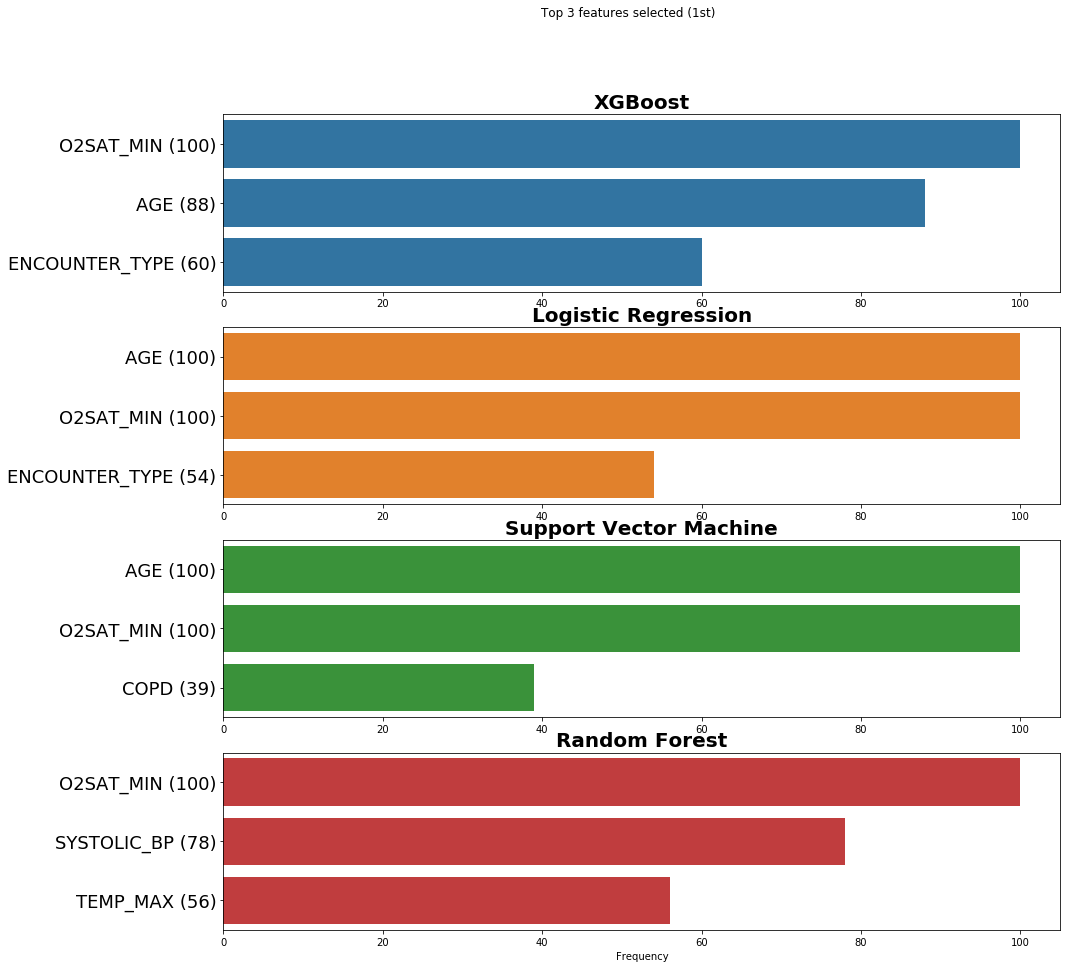

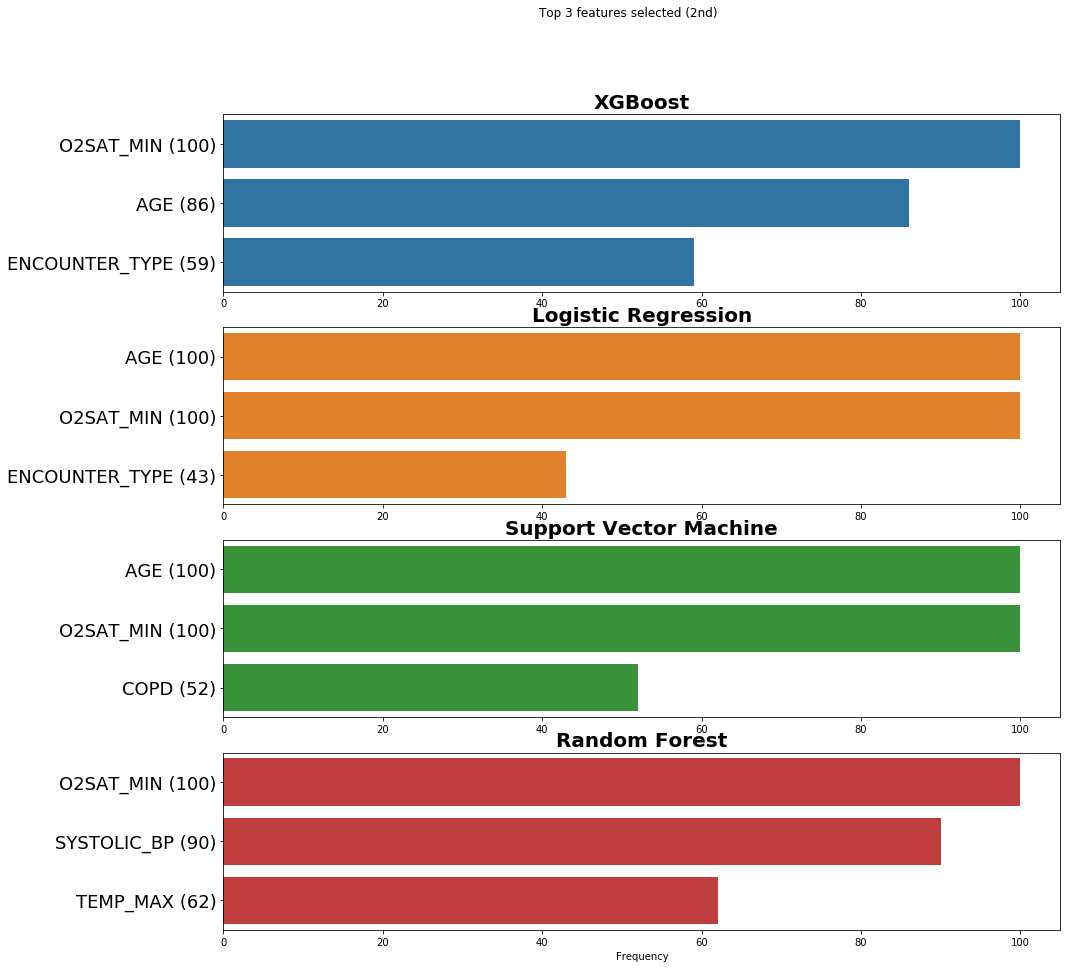

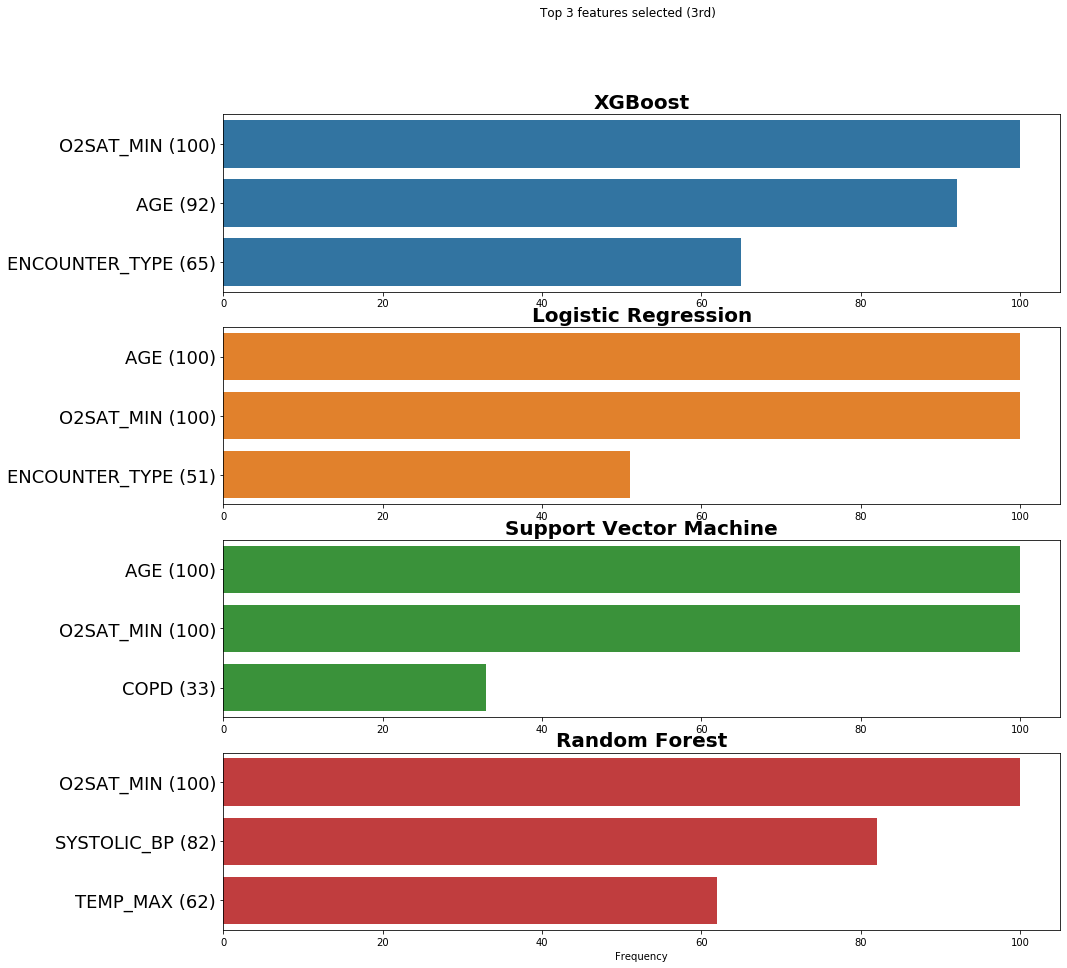

In [68]:
estimator_full_name_dict = {'XGBoost': 'XGBoost',
            'LR': 'Logistic Regression',
            'SVM': 'Support Vector Machine',
            'RF': 'Random Forest'}


# histogram plot
top_n_list = [3]
for top_n in top_n_list:
    top_n_df = all_result_df[all_result_df['num_features_picked'] == top_n]
    freq_df_list = []
    for set_idx, set_of_seed in enumerate(three_set_of_seed):
        freq_df = pd.DataFrame(columns=['set_to_run', 'classifier', 'freq', 'feature'])
        feature_frequency_dict_by_clf = dict()
        fig2, axs = plt.subplots(4, figsize=(15,15))


        in_seed_range = (top_n_df['seed'] <= set_of_seed[-1]) & (top_n_df['seed'] >= set_of_seed[0])
        top_n_df_by_seed_set = top_n_df[in_seed_range]


        for est_idx, (est_name, est) in enumerate(estimator_dict.items()):
            top_n_df_by_clf = top_n_df_by_seed_set[top_n_df_by_seed_set['classifier']==est_name]
            
            for idx, f_name in enumerate(feature_name_list):
                freq = sum(top_n_df_by_clf[f_name].values)
                dict_to_append = {'set_to_run': set_idx, 'classifier': est_name,
                                  'freq': freq, 'feature': f_name}
                freq_df = freq_df.append(dict_to_append, ignore_index=True)


            freq_df_est = freq_df[freq_df['classifier']==est_name]
            freq_df_est = freq_df_est.sort_values(by=['freq'], ascending=False).iloc[:top_n]
            axs[est_idx] = sns.barplot(ax=axs[est_idx], x="freq", y="feature", data=freq_df_est, orient='h', color=cp[est_idx])
            axs[est_idx].set_title(estimator_full_name_dict[est_name], fontweight='bold',fontsize = 20)
            # axs[est_idx].set_xticks(range(len(set_of_seed)))
            axs[est_idx].set_xlabel('')
            new_yticks_label = []
            axs[est_idx].set_ylabel('')
            for idx, yticks in enumerate(axs[est_idx].get_yticklabels()):
                new_yticks_label.append("{} ({})".format(yticks.get_text(), freq_df_est['freq'].iloc[idx]))
            axs[est_idx].set_yticklabels(new_yticks_label, fontsize=18)
            
            if est_idx < len(estimator_dict)-1:
                axs[est_idx].set_xlabel('')
            else:
                axs[est_idx].set_xlabel('Frequency')
        fig2.suptitle('Top {} features selected ({})'.format(top_n, make_ordinal(set_idx+1)))
        fig2.savefig('top{}_frequency_by_clf_{}.tif'.format(top_n, set_idx + 1), bbox_inches="tight")

In [ ]:
#all_result_df = pd.read_csv('RFE_result_RL.csv')